In this last post of the Bayesian Modeling for Oceanographers series, I will demonstrate the development of hierarchical models, illustrated through modeling chlorophyll as a function of remote sensing reflectance. Hierarchical models are particularly useful, and are in fact the recommended default, whenever there is a possibility of grouping the data in a meaningful way. This opportunity for clustering is readily available in the NOMAD dataset; a dataset that is commonly used for the development of algorithms aimed at biological satellite oceanography.<br>
Most models, including those encoutered in the oceanographic literature, pool data in order to capture global trends; they are commonly referred to as '<u>**pooled models**</u>'. The problem is that pooled models often run into trouble when the data they are fed depart from trends and conditions that dominate the training dataset. This is the case, for example, when a model trained on a set of predominantly blue water observations is given data collected from optically complex coastal sites. Even if similar data are present in the training data, pooled models are not structured to capture local conditions. The result is a loss of potentially valuable information. Moreover, when pooled models are developed using a varied dataset that includes many different environments, the temptation is great for the practitioner to resort to complicated mathematical expressions. While such models are capable of noteworthy performance they are typically difficult to interpret. This has caused the remote sensing community, among others, to create a false dichotomy separating kludgy uninterpretable but practical "empirical models"  from "analytical" or "semi-analytical" models, perceived as principled alternatives that are challenging to work with.<br>
To address the issue of applicability to local conditions, there has been a number of attempts at developing and training models tuned to specific environments. These <u>**unpooled models**</u> have been demonstrably successful, are often simpler in construction and therefore are more readily interpretable and are often reuseable in locations or periods beyond their original application. This however, requires retraining the model by replacing the training data describing one specific environment with a dataset representing another set of conditions. Such a reset in model training results in the loss of information contained in the discarded observations This induced 'model amnesia' wastes already sparse *in-situ* data, and fails to maximize the information content of datasets like NOMAD.<br>

#### Partially pooled models
A solution to maximize the information content of a dataset is the '<u>***partially pooled***</u>' model. Assuming a regression model, where $\alpha$ is the intercept and $\beta$ is the slope multiplying the predictor variable.<br>
The partially pooled model is so-called because it allows the formulation of group-specific models that are connected to each other. Fitting interconnected group-specific submodels allows the maximization of the information contained in the training dataset. <br>
The connection between the submodels is realized through the use of common *hyper-priors*. Hyper-priors are distributions that generate the model parameters; in this case one generates the intercepts and one generates the slopes. Such framework, detailed below (*cf.* **Fig. 1**) enables the flow of information between submodels resulting in localized fits constrained by global trends. Among others, this addresses, in a principled way, the oft-encountered issue of imbalanced datasets, where a handful of locations is more sampled than others.
<br>
<figure>
<img src='figJar/Hierarchical_models/hierarchical_mlr.png'>
<figcaption><strong>Fig. 1.</strong> Schema of a hierarchical bayesian multi-linear regression model with data grouped into N categories. </figcaption>
</figure>
<br>

#### Clustering the NOMAD dataset

For illustration I use the NOMAD dataset to estimate in situ chlorophyll from remote sensing reflectance. The model I use is a simple linear regression, where the predictor is the ratio $\frac{max(Rrs(412), Rrs(489), Rrs(510))}{Rrs(555)}$; the same as the operational $OC_4$ algorithm. Here however, there is no projection of the input into high dimensional space. The coefficients of this linear regression, intercept ($\alpha$) and slope ($\beta$), are the target of the bayesian inference implemented below, as shown in **Fig. 1**

For the purpose of this tutorial I will use a simple 3 grouping schemes, the first of which is suggested by the algorithm itself. These include: 
* blue band used in the ratio - 443, 489, 510;
* biogeographic region type - polar, coastal, trade wind-dominated, westerly wind-dominated;
* biogeographic forcing - represented by Longhurst biogeographical provinces - *cf.* **Fig. 2**. 

In addition to these 3 partially pooled models, I will also fit a global model using the original OC_4 formulation. Finally I rank all four models using via information theory-based assessment as well as cross validation performance.
<br>

<figure>
<img src='figJar/Hierarchical_models/lhurstbiogeog.jpg'>
<figcaption><strong>Fig. 2.</strong> Longhurst regions above are used to classify observations as being subject to a particular biogeographical forcing. </figcaption>
</figure>


In [2]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot, jointplot, FacetGrid, distplot
from scipy.stats import skew
import theano.tensor as tt
import re
from matplotlib import cm
from cmocean import cm as cmo
from matplotlib.colors import rgb2hex

In [3]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18

The first thing that we can see from the imputation of the data, documented in an [earlier notebook](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb), is that the pattern in the data no longer supports necessarily a high order polynomial such as OC4. Instead, I will model the band contribution as a simpler and more readily interpretable first order regression on $log(max(blue)) - log(green)$. I will then compare the performance of the resulting models with that of a fourth order polynomial regression, similar to OC4.
<br>
The data also shows good separability with respect to the blue band used in the ratio; both in terms of chlorophyll and band ratio distributions.<br> This clustering scheme can be used to add information to the data fit. As such it will be part of the hierarchical model architecture presented below.
<br>
Another source of information that can be used for clustering is location. A simple and familiar scheme that can be used is Longhurst biogeographical province distribution.
 For context, the Longhurst map looks as follows:


An exploratory plot depicting the data distribution by province is available here.

The relationship of the various models proposed with chl_l, including the legacy OC4 algorithm, given the new augmented dataset fail to justify anything but a one degree polynomial. Another motivation to refrain from compounding the predictor variables is the interpretability the associated model parameters, the interpretability of which thus remains feasible. This does not preclude having to deal with potentially complicated relationships between predictor and predicted variables. A better way to address complexity is to use more predictor variables, and increase the flexibility of the models tested by using clustering within the data. Such flexibility can be achieved with the use of hierarchical models.

### Bayesian Hierarchical Models

Quoting from Betancourt & Girolami (2013):
"Hierarchical models are defined by the organization of a model's parameters into exchangeable groups, and the resulting conditional independencies between those groups."

Inference in a hierarchical model is conducted on multiple levels with cluster-specific parameters  with one or more common priors,  referred to as *hyper-priors*. Hyper-priors constitute a link through which information between clusters can flow during model fitting.

Structurally, and unlike models seen in [the earlier post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb), hierarchical models have:

* one set of priors for each cluster
* a common set of priors for the cluster priors. These hyperpriors are the constructs that allow information to flow between the different clusters.

I will illustrate the above with a diagram for the models. As shown above, there are three clusterings to choose from, including *mxblID*, *biome*, and *province*. Based on earlier diagnostics I will use *mxblID* and *province*. Note that even when max(blue) is not included in the predictor variable used, it still represent a potentially important piece of information on each observation. I therefore include it regardless of the model being fit.



In [23]:
df = pd.read_pickle('./pickleJar/df_log.pkl')

In [20]:
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [4]:
blue_mapping = dict(enumerate(df['mxBlId'].astype('category').cat.categories))
biome_mapping = dict(enumerate(df['biome'].astype('category').cat.categories))
prov_mapping = dict(enumerate(df['provCode'].astype('category').cat.categories))

In [5]:
d_ = df[['mxBlId','provCat','mxBlCat', 'biomCat', 'MxBl-Gr',
         'oisst', 'etopo2_l', 'chl', 'chl_l']].dropna()
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 9 columns):
mxBlId      4126 non-null object
provCat     4126 non-null int8
mxBlCat     4126 non-null int8
biomCat     4126 non-null int8
MxBl-Gr     4126 non-null float64
oisst       4126 non-null float64
etopo2_l    4126 non-null float64
chl         4126 non-null float64
chl_l       4126 non-null float64
dtypes: float64(5), int8(3), object(1)
memory usage: 237.7+ KB


In [7]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
n_biomes = d_.biomCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
biomeIdx = d_.biomCat.values
log_band_ratio = d_['MxBl-Gr'].values
log_depth = d_['etopo2_l'].values
sst = d_['oisst'].values
predicted = d_['chl_l'].values

#### <u>Baseline Model - The OC4 Clone</u>

In [41]:
with pm.Model() as m0:
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10, shape=4)
    sigma_model = pm.HalfCauchy('sigma_model', beta=5)
    mu_ = alpha + beta[0] * log_band_ratio + beta[1] * log_band_ratio ** 2 +\
        beta[2] * log_band_ratio**3 + beta[3] * log_band_ratio**4
    log_chl = pm.Normal('log_chl', mu=mu_, sd=sigma_model, observed=predicted)
    trace_0 = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_model_log__, b, a]
  5%|▍         | 455/10000 [00:09<03:28, 45.69it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [03:38<00:00, 45.67it/s]


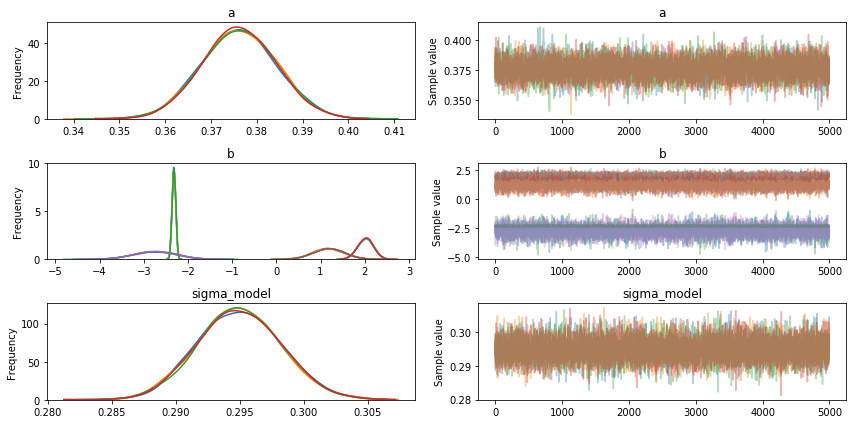

In [42]:
pm.traceplot(trace_0);

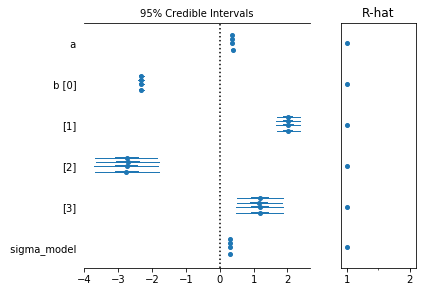

In [43]:
pm.forestplot(trace_0);

### <u> Hierarchical Models</u>
#### <u>The Max(Blue)-Clustered Model</u>

In [8]:
with pm.Model() as mdl_bl:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_blue = pm.Normal('a_blue', mu=mu_a, sd=sigma_a, shape=n_blues)
    b_blue = pm.Normal('b_blue', mu=mu_b, sd=sigma_b, shape=n_blues)
    
    #forward model & model error
    mu_ = a_blue[blueIdx] + b_blue[blueIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_blue, a_blue, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
 10%|▉         | 956/10000 [00:09<01:34, 95.79it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [01:07<00:00, 148.26it/s]
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.702834512364031, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Model Diagnostics

In [9]:
pm.summary(trace_bl)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.355913,0.365036,0.007997,-0.243873,0.958039,2125.193049,1.001048
mu_b,-2.133977,1.183655,0.020802,-4.398306,0.224003,3447.214619,1.000149
a_blue__0,0.439375,0.021834,0.000241,0.397735,0.482939,10618.286545,0.999989
a_blue__1,0.236244,0.015510,0.000165,0.205532,0.265892,9831.388563,0.999902
a_blue__2,0.381081,0.010744,0.000088,0.360092,0.402039,13743.027786,1.000112
b_blue__0,-1.941695,0.036065,0.000385,-2.014456,-1.873735,10911.682760,0.999961
b_blue__1,-1.422457,0.066267,0.000743,-1.551803,-1.294331,9549.825225,1.000005
b_blue__2,-3.052507,0.081642,0.000711,-3.212966,-2.893088,13952.912394,1.000149
sigma_a,0.361902,0.516460,0.009590,0.036200,1.177666,2662.094239,1.000673
sigma_b,1.573177,1.396018,0.018811,0.324146,3.768398,4438.142382,1.000891


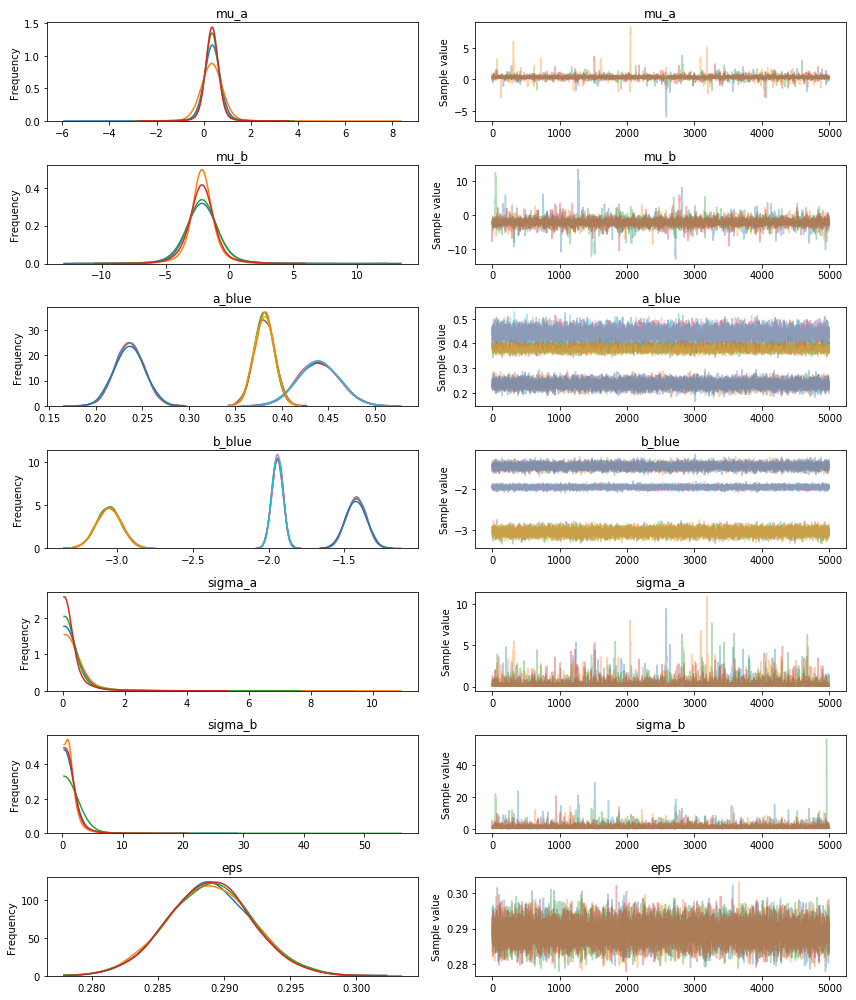

In [10]:
pm.traceplot(trace_bl);

#### Posterior Predictive Checks

In [152]:
# ppc on max-blue-band clustering
ppc_log_chl_bl = pm.sample_ppc(trace_bl, samples=1000, model=mdl_bl)['log_chl']

d_['pred_chl_l_bl_mean'] = ppc_log_chl_bl.mean(axis=0)

hpd_ppc_log_chl_bl = pm.hpd(ppc_log_chl_bl)
d_['pred_chl_l_bl_95lo'] = hpd_ppc_log_chl_bl[:, 0]
d_['pred_chl_l_bl_95hi'] = hpd_ppc_log_chl_bl[:, 1]
# Plot 

100%|██████████| 1000/1000 [00:00<00:00, 2019.41it/s]


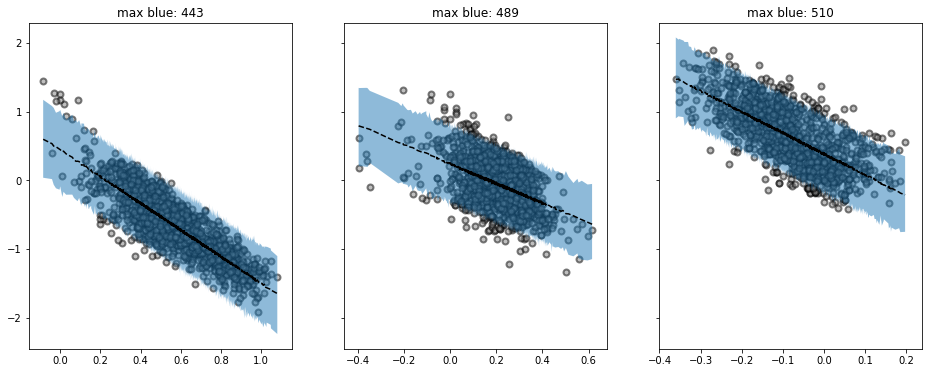

In [21]:
_, ax = pl.subplots(ncols=n_blues, figsize=(16, 6), sharey=True)
bands = ['443', '489' ,'510']
for i in range(n_blues):
    xy = d_.loc[d_.mxBlCat==i, ['MxBl-Gr', 'pred_chl_l_bl_mean', 'pred_chl_l_bl_95lo', 
                                'pred_chl_l_bl_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                 alpha=0.5, linewidth=2)
    ax[i].set_title(f'max blue: {bands[i]}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

#### <u>Biome-clustered model</u>

In [22]:
with pm.Model() as mdl_biom:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_biome = pm.Normal('a_biome', mu=mu_a, sd=sigma_a, shape=n_biomes)
    b_biome = pm.Normal('b_biome', mu=mu_b, sd=sigma_b, shape=n_biomes)
    
    #forward model & model error
    mu_ = a_biome[biomeIdx] + b_biome[biomeIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_biom = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_biome, a_biome, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
 13%|█▎        | 1326/10000 [00:09<01:04, 133.52it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:43<00:00, 228.88it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8114898772280278, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.832747905234835, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters

#### Model Diagnostics

In [23]:
pm.summary(trace_biom)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.394693,0.224920,0.004052,0.008586,0.804655,3159.599172,1.000650
mu_b,-1.977085,0.260478,0.005403,-2.474731,-1.509529,2548.928569,1.001077
a_biome__0,0.368627,0.007912,0.000058,0.352979,0.383782,20543.695892,1.000042
a_biome__1,0.616437,0.011898,0.000099,0.593164,0.639957,13668.124438,0.999978
a_biome__2,0.361564,0.016019,0.000128,0.329689,0.392176,13634.926908,0.999990
a_biome__3,0.227254,0.015779,0.000123,0.196480,0.258153,14996.455130,1.000120
b_biome__0,-2.214039,0.027206,0.000187,-2.266720,-2.159911,19709.172395,0.999980
b_biome__1,-2.038993,0.033837,0.000277,-2.106040,-1.974069,13977.473847,0.999989
b_biome__2,-1.885840,0.027693,0.000206,-1.938540,-1.830417,14831.659781,0.999946
b_biome__3,-1.754105,0.029258,0.000240,-1.812130,-1.697052,14813.960854,1.000116


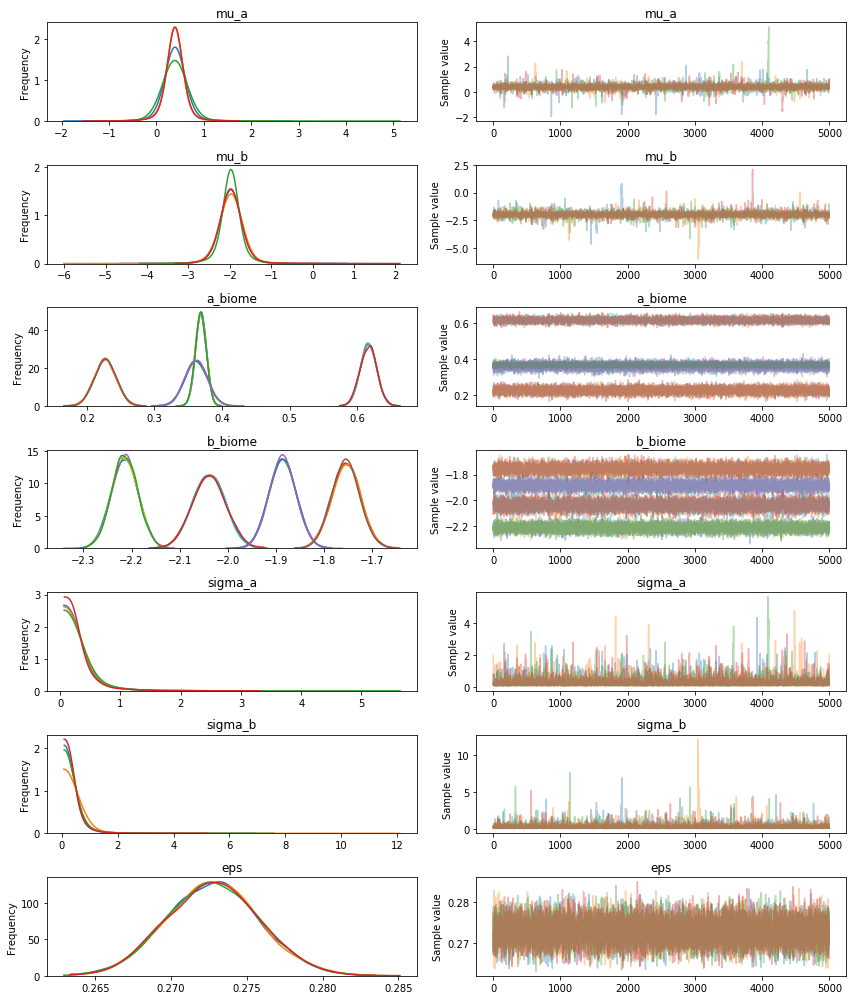

In [24]:
pm.traceplot(trace_biom);

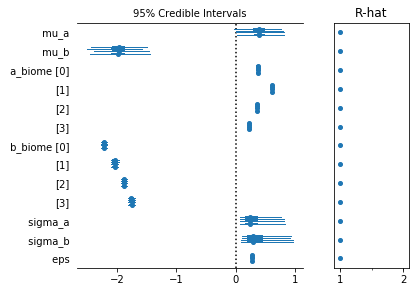

In [25]:
pm.forestplot(trace_biom);

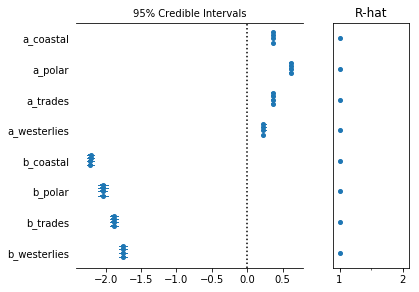

In [27]:
pm.forestplot(trace_biom, varnames=['a_biome', 'b_biome'], 
              ylabels=['a_coastal', 'a_polar', 'a_trades', 'a_westerlies',
                      'b_coastal', 'b_polar', 'b_trades', 'b_westerlies']);

#### Posterior Predictive Checks

In [28]:
# ppc on max-blue-band clustering
ppc_log_chl_biom = pm.sample_ppc(trace_biom, samples=1000, model=mdl_biom)['log_chl']

d_['pred_chl_l_biom_mean'] = ppc_log_chl_biom.mean(axis=0)

hpd_ppc_log_chl_biom = pm.hpd(ppc_log_chl_biom)
d_['pred_chl_l_biom_95lo'] = hpd_ppc_log_chl_biom[:, 0]
d_['pred_chl_l_biom_95hi'] = hpd_ppc_log_chl_biom[:, 1]
del ppc_log_chl_biom, hpd_ppc_log_chl_biom

100%|██████████| 1000/1000 [00:00<00:00, 1840.16it/s]


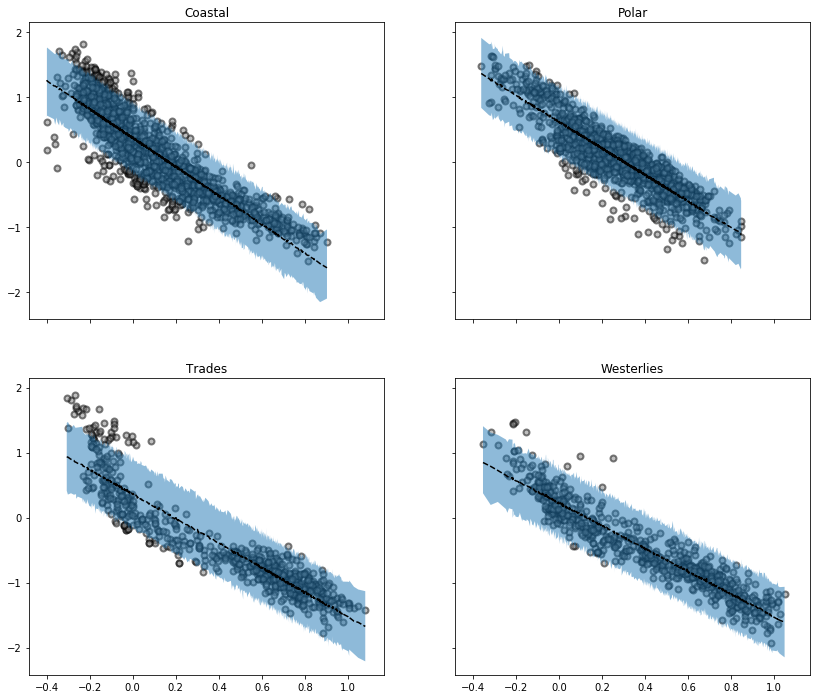

In [32]:
_, axs = pl.subplots(ncols=2, nrows=2, figsize=(14, 12), sharey=True, sharex=True)
ax = axs.ravel()
for i in range(n_biomes):
    xy = d_.loc[d_.biomCat==i, ['MxBl-Gr', 'pred_chl_l_biom_mean', 'pred_chl_l_biom_95lo', 
                                'pred_chl_l_biom_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                 alpha=0.5, linewidth=2)
    ax[i].set_title(f'{biome_mapping[i]}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

#### <u>Province-clustered model</u>

In [33]:
with pm.Model() as mdl_prov:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sigma_a, shape=n_provinces)
    b_prov = pm.Normal('b_prov', mu=mu_b, sd=sigma_b, shape=n_provinces)
    
    #forward model & model error
    mu_ = a_prov[provIdx] + b_prov[provIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_prov = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_prov, a_prov, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
  5%|▍         | 485/10000 [00:09<03:14, 48.94it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [02:25<00:00, 68.54it/s]


#### Model Diagnostics

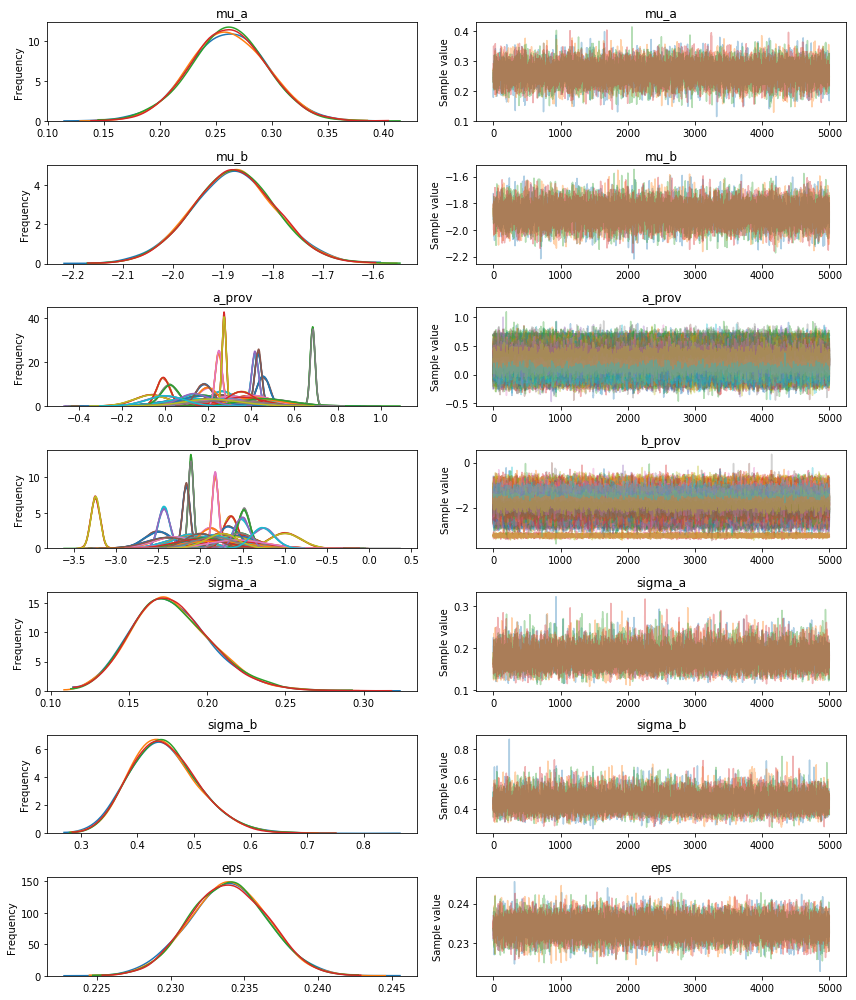

In [34]:
pm.traceplot(trace_prov);

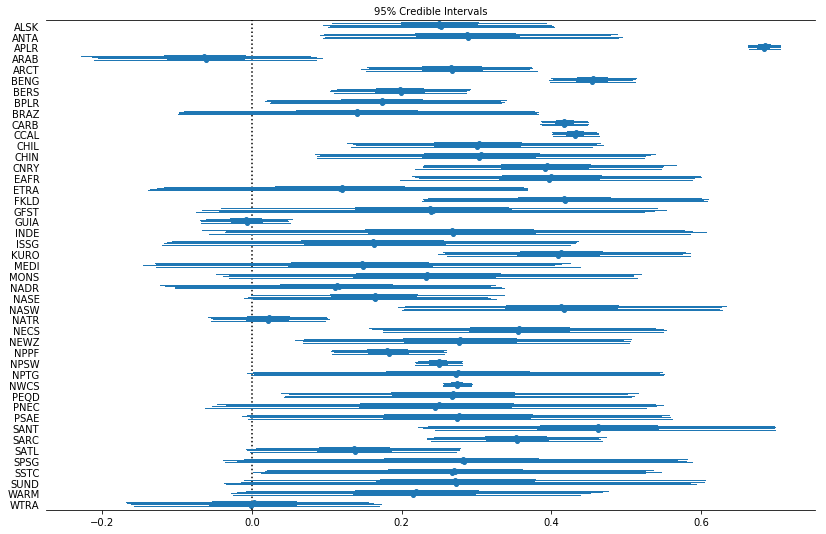

In [36]:
gs = pm.forestplot(trace_prov, varnames=['a_prov'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(12)

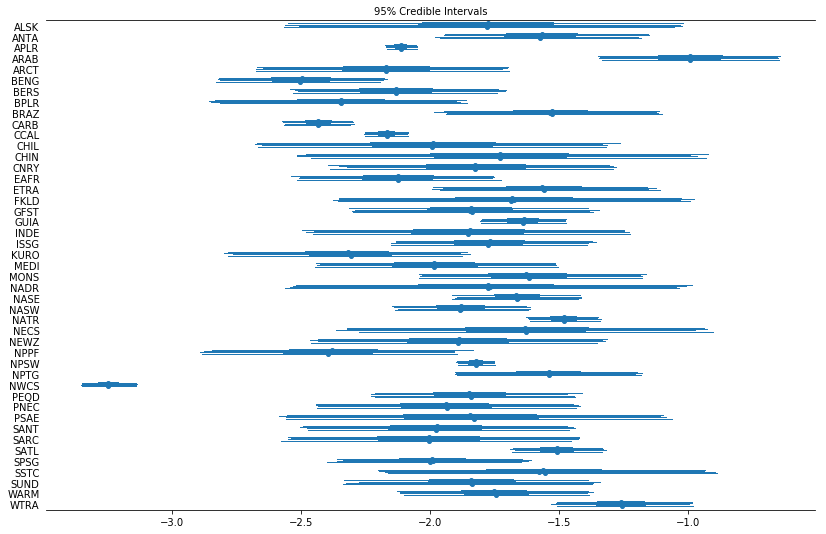

In [35]:
gs = pm.forestplot(trace_prov, varnames=['b_prov'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(12)

#### Posterior Predictive Checks

In [71]:
# ppc on max-blue-band clustering
ppc_log_chl_prov = pm.sample_ppc(trace_prov, samples=1000, model=mdl_prov)['log_chl']
d_['pred_chl_l_prov_mean'] = ppc_log_chl_prov.mean(axis=0)
hpd_ppc_log_chl_prov = pm.hpd(ppc_log_chl_prov)
d_['pred_chl_l_prov_95lo'] = hpd_ppc_log_chl_prov[:, 0]
d_['pred_chl_l_prov_95hi'] = hpd_ppc_log_chl_prov[:, 1]
del ppc_log_chl_prov, hpd_ppc_log_chl_prov

100%|██████████| 1000/1000 [00:00<00:00, 1829.13it/s]


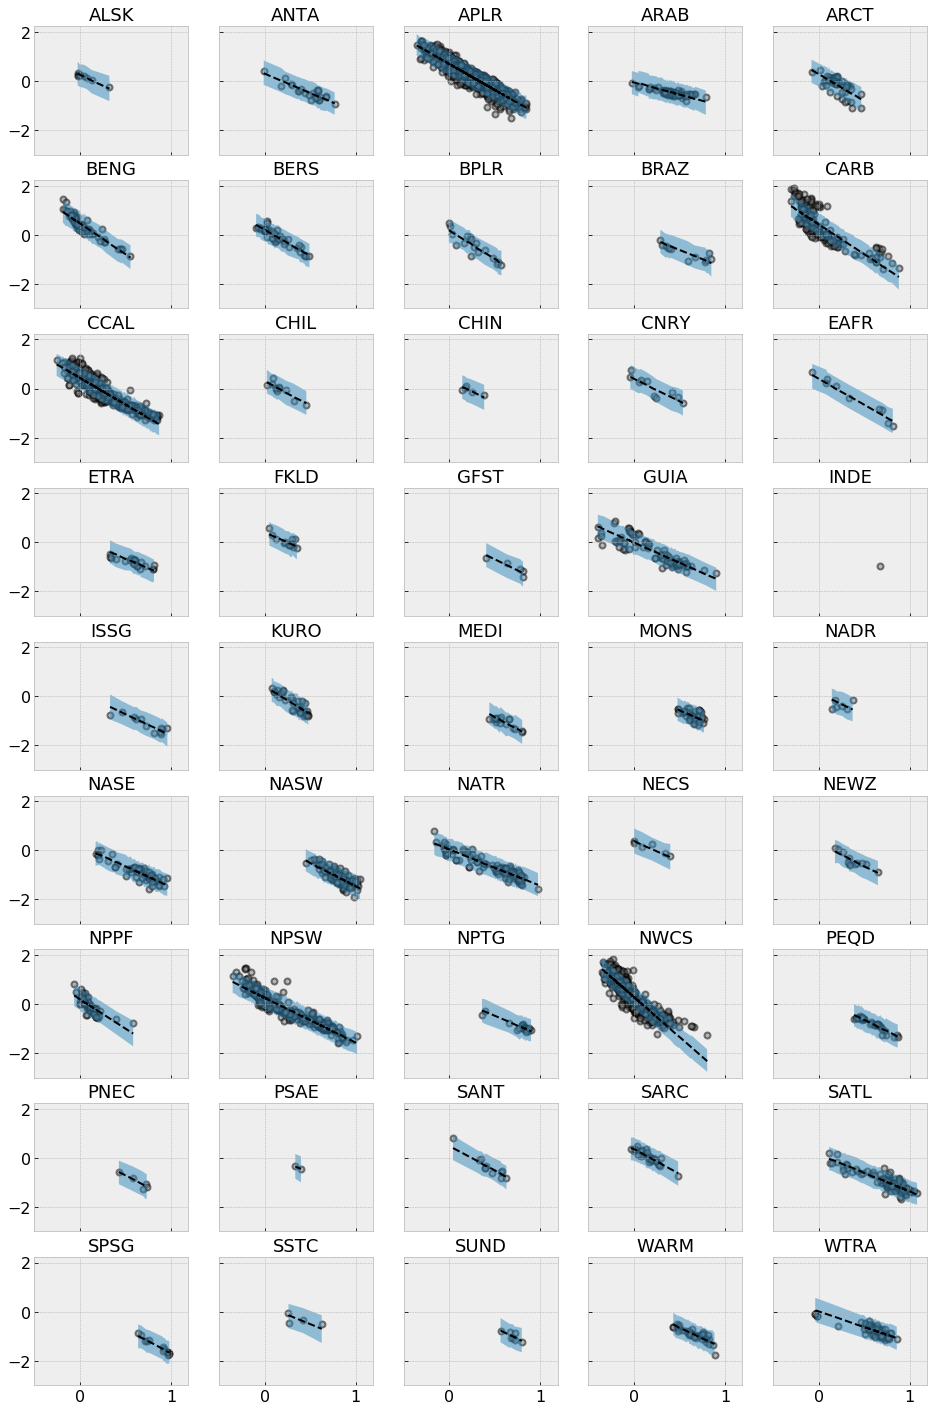

In [147]:
_, axs = pl.subplots(nrows=9, ncols=5, figsize=(16, 25), sharex=True, sharey=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.provCat==i, ['MxBl-Gr', 'pred_chl_l_prov_mean', 'pred_chl_l_prov_95lo', 
                                'pred_chl_l_prov_95hi', 'chl_l']].values

    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2, label=leg[0])
    ax[i].set_title(f'{prov}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--', label=leg[1])
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5, )

### <u> Hierarchical Models with Covarying Slopes and Intercepts</u>

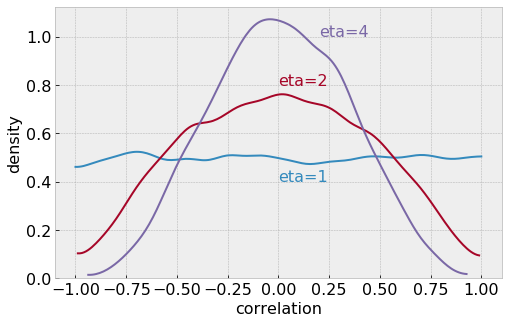

In [150]:
f, ax = pl.subplots(figsize=(8, 5))
textlocs = [[0, 0.4,], [0, 0.8], [0.2, 1]]
for i, (loc, eta) in enumerate(zip(textlocs, [1, 2, 4])):
    r = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(r, ax=ax)
    ax.text(loc[0], loc[1], f'eta={eta}', color=ax.lines[i].get_color())
ax.set_xlabel('correlation')
ax.set_ylabel('density');
f.savefig('./figJar/Hierarchical models/lkjcholprior.png', dpi=300, format='png')

#### <u>Biogeochemical Province-Clustered Model with Covarying Slopes and Intercepts</u>

In [62]:
with pm.Model() as mdl_prov_cov_nc:
    # hyperpriors
    # -----------
    a_prov_hyp = pm.Normal('a_prov_hyp', 0, 10) # intercept hyperprior
    b_prov_hyp = pm.Normal('b_prov_hyp', 0, 1) # slope hyperprior
    sd_dist = pm.HalfCauchy.dist(beta=2)
    # cov hyperprior
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=4, n=2, sd_dist=sd_dist)
    
    # priors
    # ----------
    # convert triangular cholesky factor matrix to 2D array
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    # compute prior on intercept and slope
    ab_prov = pm.MvNormal('ab_prov', mu=np.zeros(2), chol=chol, shape=(n_provinces, 2))
    
    # extract intercepts
    a_prov = pm.Deterministic('a_prov', ab_prov[:, 0] + a_prov_hyp)
    # extract slopes
    b_prov = pm.Deterministic('b_prov', ab_prov[:, 1] + b_prov_hyp)
    # extract correlation (rho)
    cov = tt.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # forward model & model error
    mu_ = a_prov[provIdx] + b_prov[provIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=2)
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_prov_cov_nc = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, ab_prov, chol_cov_cholesky_cov_packed__, b_prov_hyp, a_prov_hyp]
  1%|          | 86/10000 [00:09<18:59,  8.70it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [05:53<00:00, 28.25it/s]
The number of effective samples is smaller than 25% for some parameters.


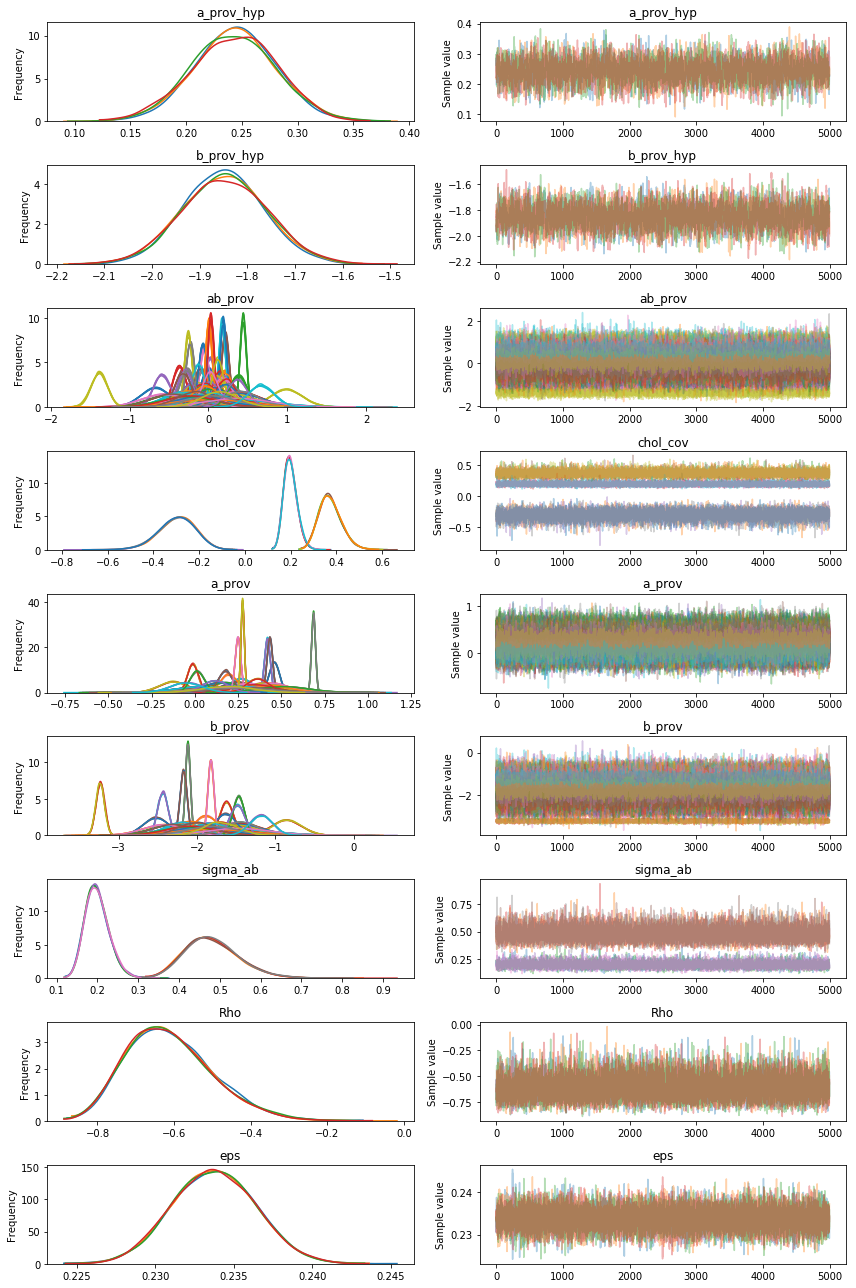

In [63]:
pm.traceplot(trace_prov_cov_nc);

In [76]:
d_.drop(['pred_chl_l_prov_cov_nc_95hi'], axis=1, inplace=True)

In [77]:
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 19 columns):
mxBlId                         4126 non-null object
provCat                        4126 non-null int8
mxBlCat                        4126 non-null int8
biomCat                        4126 non-null int8
MxBl-Gr                        4126 non-null float64
oisst                          4126 non-null float64
etopo2_l                       4126 non-null float64
chl                            4126 non-null float64
chl_l                          4126 non-null float64
pred_chl_l_bl_mean             4126 non-null float64
pred_chl_l_bl_95lo             4126 non-null float64
pred_chl_l_bl_95hi             4126 non-null float64
pred_chl_l_biom_mean           4126 non-null float64
pred_chl_l_biom_95lo           4126 non-null float64
pred_chl_l_biom_95hi           4126 non-null float64
pred_chl_l_prov_mean           4126 non-null float64
pred_chl_l_prov_95lo           4126 non-null float64
pr

In [78]:
ppc_log_chl_prov = pm.sample_ppc(trace_prov_cov_nc,
                                 samples=1000, model=mdl_prov_cov_nc)['log_chl']
d_['pred_chl_l_prov_cov_nc_mean'] = ppc_log_chl_prov.mean(axis=0)
hpd_ppc_log_chl_prov = pm.hpd(ppc_log_chl_prov)
d_['pred_chl_l_prov_cov_nc_95lo'] = hpd_ppc_log_chl_prov[:, 0]
d_['pred_chl_l_prov_cov_nc_95hi'] = hpd_ppc_log_chl_prov[:, 1]
del ppc_log_chl_prov, hpd_ppc_log_chl_prov

100%|██████████| 1000/1000 [00:00<00:00, 1832.35it/s]


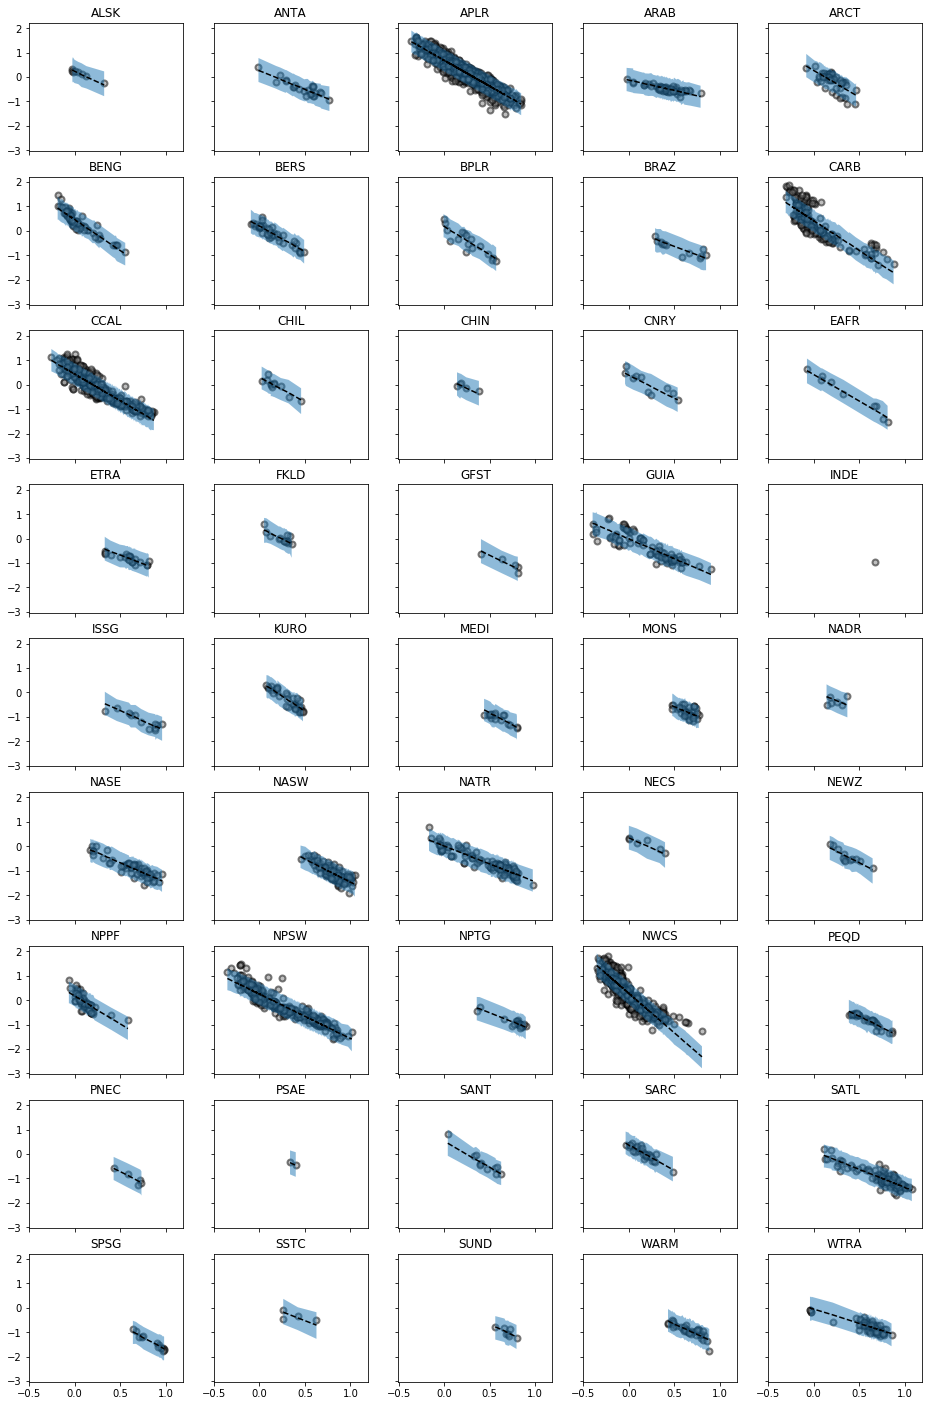

In [79]:
_, axs = pl.subplots(nrows=9, ncols=5, figsize=(16, 25), sharex=True, sharey=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.provCat==i, ['MxBl-Gr', 'pred_chl_l_prov_cov_nc_mean',
                                'pred_chl_l_prov_cov_nc_95lo', 
                                'pred_chl_l_prov_cov_nc_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2)
    ax[i].set_title(f'{prov}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

### <u> Model Comparison</u>

#### Comparing Posterior Predictive Density Distributions to Data

Here I perform a qualitative comparison between the kernel density estimate and many samples drawn from the posterior predictive distribution of each model to see which model is able to simulate new data that are more similar to the observations on hand. This is a qualitative plot that helps provide a more complete picture of how well the model is doing.

In [179]:
ppc_dict = {}
ppc_dict['pooled'] = pm.sample_ppc(trace_0, samples=1000, model=m0)['log_chl']
ppc_dict['blue-clustered'] = pm.sample_ppc(trace_bl, samples=1000, model=mdl_bl)['log_chl']
ppc_dict['biome-clustered'] = pm.sample_ppc(trace_biom, samples=1000,
                                         model=mdl_biom)['log_chl']
ppc_dict['province-clustered'] = pm.sample_ppc(trace_prov, samples=1000,
                                       model=mdl_prov)['log_chl']
ppc_dict['prov.-clust.-w/cov'] = pm.sample_ppc(trace_prov_cov_nc, samples=1000,
                               model=mdl_prov_cov_nc)['log_chl']

100%|██████████| 1000/1000 [00:00<00:00, 1830.58it/s]


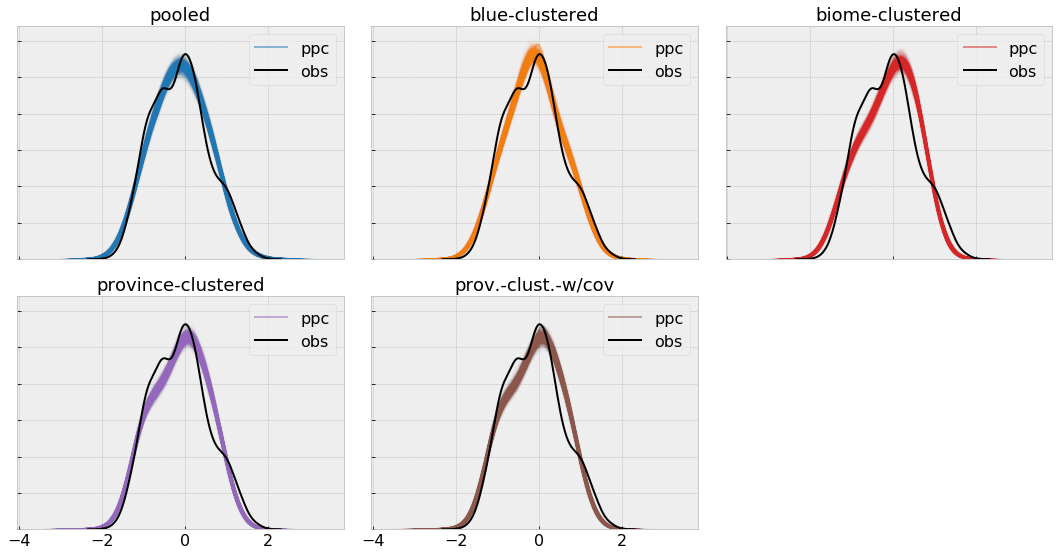

In [186]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
cm_ = cm.get_cmap('tab10')
cmh = [rgb2hex(cm_(i)[:3]) for i in [0, 1, 3, 4, 5]]
for axi, (key, val), col_hex in zip(ax[:-1], ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    for i in range(val.shape[0]):
        if i == 0:
            kdeplot(val[i], color=col_hex, alpha=0.5, ax=axi, label='ppc')
        else:
            kdeplot(val[i], color=col_hex, alpha=0.01, ax=axi)

    kdeplot(predicted, ax=axi, linewidth=2, color='k', label='obs')
ax[-1].set_visible(False)
f.tight_layout()
f.savefig('./figJar/kdeDensComp.png', dpi=300, format='png')

#### Skewness
Another possible check is comparison of skewness between the data and multiple draws from the posterior predictive distribution

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


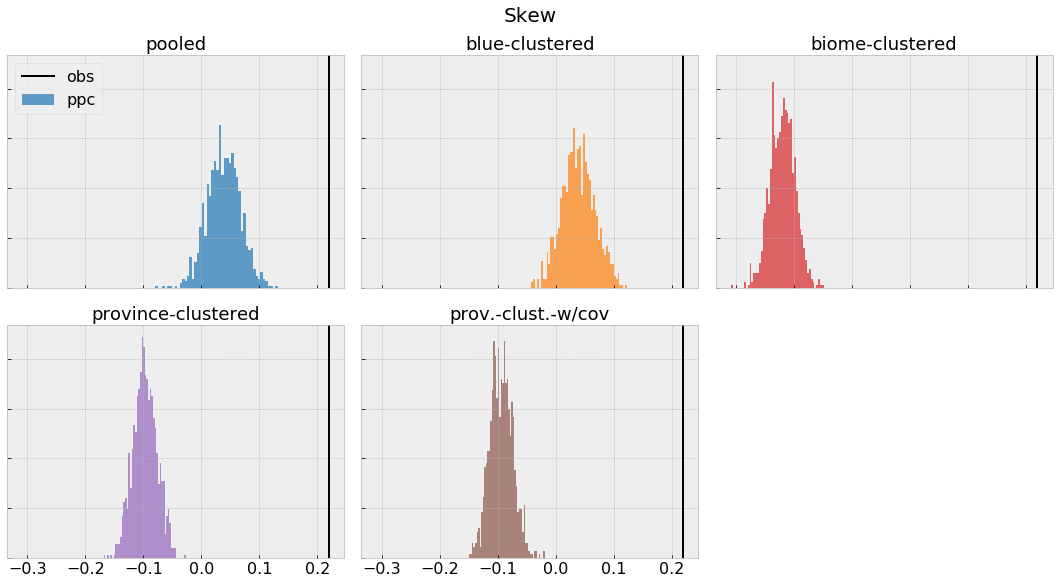

In [207]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
data_skew = skew(predicted)
for axi, (key, val), col_hex in zip(ax[:-1], ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    skewness = skew(val, axis=1)
    distplot(skewness, bins=50, ax=axi, kde=False, color=col_hex,
             hist_kws=dict(alpha=0.7, normed=True))
    axi.axvline(data_skew, linewidth=2, color='k')
ax[-1].set_visible(False)
ax[0].legend(['obs', 'ppc'])
f.suptitle('Skew', y=1.02)
f.tight_layout()
f.savefig('./figJar/skewnessComp.png', dpi=300, format='png')

Overall, the blue-clustered and pooled model show the closest skew to that of the data.

#### Within-group comparison
Here, I do pairwise pooled-other model comparison looking at the in-group performance for each model.
##### Pooled vs. blue-clustered model


#### Watanabe Akaike Information Criterion (WAIC) and Leave-One-Out Cross Validation (LOOCV)

In [87]:
# pickle models
traces = [trace_0, trace_bl, trace_biom, trace_prov, trace_prov_cov_nc]
m0.name = 'pooled'
mdl_bl.name = 'blue_clustered'
mdl_biom.name = 'biome_clustered'
mdl_prov.name = 'province_clustered'
mdl_prov_cov_nc.name = 'province_clustered_cov_effects'
mdls = [m0, mdl_bl, mdl_biom, mdl_prov, mdl_prov_cov_nc]
mdl_dict = {m.name: {'mdl': m, 'trc': t} for m, t in zip(mdls, traces)}

mdl_dict.update(dict(data=d_))

In [88]:
df_comp_waic = pm.compare({mdl: trace for mdl, trace in zip(mdls, traces)})
df_comp_waic

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
province_clustered_cov_effects,-236.63,47.27,0,0.93,117.42,0,1
province_clustered,-229.71,47.4,6.93,0,117.49,2.61,1
biome_clustered,998.23,10.27,1234.87,0,113.35,79.58,0
blue_clustered,1470.22,8.06,1706.85,0.07,88.74,92.89,0
pooled,1641.3,8.76,1877.94,0,103.55,103.52,1


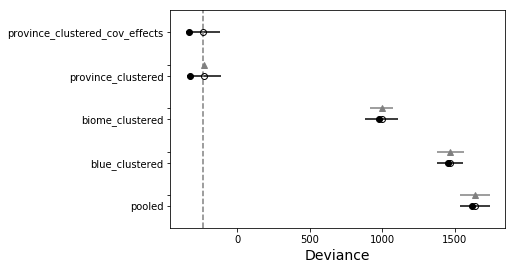

In [89]:
pm.compareplot(df_comp_waic);

In [90]:
df_comp_loo = pm.compare({mdl: trace for mdl, trace in zip(mdls, traces)}, ic='LOO')
df_comp_loo

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
province_clustered_cov_effects,-235.61,47.78,0,0.93,117.43,0,0
province_clustered,-228.63,47.93,6.98,0,117.5,2.64,0
biome_clustered,998.23,10.27,1233.84,0,113.35,79.58,0
blue_clustered,1470.22,8.06,1705.83,0.07,88.74,92.9,0
pooled,1641.34,8.78,1876.95,0,103.56,103.54,0


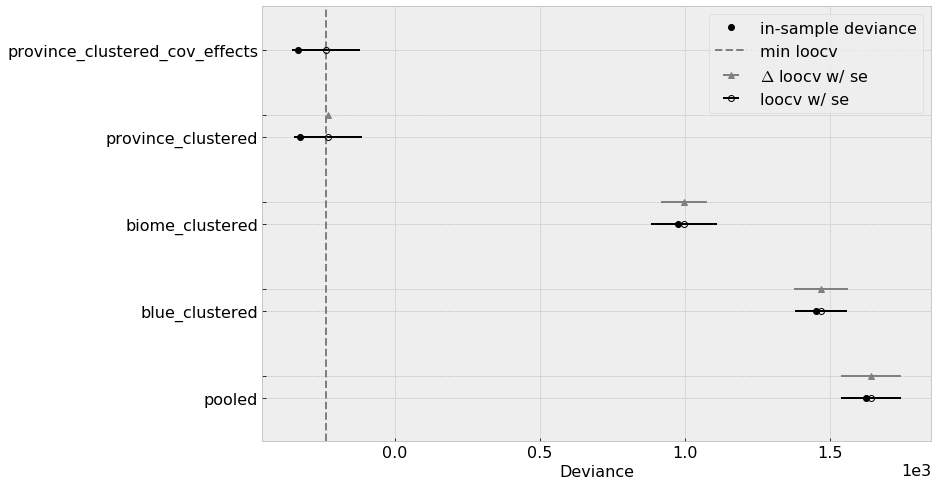

In [116]:
_, ax = pl.subplots(figsize=(12, 8))
ax = pm.compareplot(df_comp_loo, insample_dev=True, se=True, dse=True,
                    plot_kwargs=dict(fontsize=16), ax=ax)
ax.legend(['in-sample deviance', 'min loocv', r'$\Delta$ loocv w/ se', 'loocv w/ se'])

In [151]:
with open('./pickleJar/GaussianModels_single_cluster.pkl', 'wb') as f:
    pickle.dump(mdl_dict, f, protocol=pickle.HIGHEST_PROTOCOL)